# Assignment 2: Ising Model

Hope you enjoyed the first assignment! This is the jupyter notebook for the second assingnment. In this notebook, we will:

1) Initialise a system
2) Visualise the system
3) Develop a spin flip algorithm and see how the system converges to the ground state
4) Perform binning analysis for the single spin flip algorithm and evaluate the autocorrelation time
5) Apply the Swendsen-Wang or Wolff algorithm for cluster flipping
6) Perform binning analysis and evaluate the autocorrelation time for Swendsen-Wang/Wolff
7) Compare single spin flip and Swendsen-Wang/Wolff
8) Find magnetisation as a function of temperature
9) Evaluate the standard error
10) Find the autocorrelation time as a function of temperature
11) Based on all of the above, find the critical temperature of the 2D Ising model

While this is a lot, I will provide a good chunk of hints to make the process smoother. As previously stated, you will benefit more if you abstain from using LLMs here. At best it will only be useful to debug any cython errors.

Feel free to ask doubts in group or DMs!

## 1. Initialise the system

As before, initialise a grid as a 2D array. This time, simply fill this array randomly with either -1 (down spin) or +1 (up spin).

Hint: np.random.choice

In [2]:
import numpy as np

def random_spin_field(N, M): # initialise a random spin field
  return np.random.choice([-1, 1], size=(N, M))

## 2. Visualise the grid and single spin flip algorithm

Watch the following two youtube videos to get an introduction to cython. Conveniently, they are also about Ising model, so you are essentially getting this code for free

https://www.youtube.com/watch?v=rN7g4gzO2sk&list=PLcKyTzEkOa-gxU14ehctpaQdhE2GOFpeb&index=1

https://www.youtube.com/watch?v=LOzcSuw3yOY


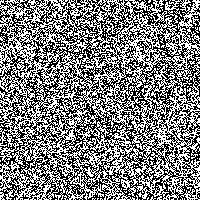

In [3]:
from PIL import Image

def display_spin_field(field): # display the field as black and white
  return Image.fromarray(np.uint8((field + 1)*0.5*255)) # 0 ... 255
display_spin_field(random_spin_field(200, 200))

In [4]:
def ising_step(field, beta=0.4): # one ising step for entire field
  N, M = field.shape
  for n_offset in range(2):
    for m_offset in range(2):
      for n in range(n_offset, N, 2):
        for m in range(m_offset, M, 2):
          ising_update(field, n, m, beta)
  return field

In [5]:
def ising_update(field, n, m, beta=0.4): # update for a single point
  total = 0
  N, M = field.shape
  for i in range(n-1, n+2):
    for j in range(m-1, m+2):
      if i == n and j == m:
        continue
      total += field[i % N, j % M]
  dE = 2 * field[n, m] * total
  if dE <= 0:
    field[n, m] *= -1
  elif np.exp(-dE * beta) > np.random.rand():
    field[n, m] *= -1

In [6]:
from ipywidgets import interact

def display_ising_sequence(images): # animate sequence of ising steps
  def show(frame=(0, len(images) - 1)):
    return display_spin_field(images[frame])
  return interact(show)

In [7]:
images = [random_spin_field(200, 200)]
for _ in range(50):
  images.append(ising_step(images[-1].copy()))
display_ising_sequence(images)

interactive(children=(IntSlider(value=25, description='frame', max=50), Output()), _dom_classes=('widget-inter…

<function __main__.display_ising_sequence.<locals>.show(frame=(0, 50))>

In [8]:
%load_ext Cython

In [9]:
%%cython

cimport cython

import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
  int RAND_MAX

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_ising_step(np.int64_t[:, :] field, float beta=0.4): # one ising step for entire field
  cdef int N = field.shape[0]
  cdef int M = field.shape[1]
  cdef int n_offset, m_offset, n, m

  for n_offset in range(2):
    for m_offset in range(2):
      for n in range(n_offset, N, 2):
        for m in range(m_offset, M, 2):
          cy_ising_update(field, n, m, beta)
  return np.array(field)

cdef cy_ising_update(np.int64_t[:, :] field, int n, int m, float beta=0.4): # update for a single point
  cdef int total = 0
  cdef int N = field.shape[0]
  cdef int M = field.shape[1]
  cdef int i, j

  for i in range(n-1, n+2):
    for j in range(m-1, m+2):
      if i == n and j == m:
        continue
      total += field[i % N, j % M]
  cdef float dE = 2 * field[n, m] * total
  if dE <= 0:
    field[n, m] *= -1
  elif exp(-dE * beta) * RAND_MAX > rand():
    field[n, m] *= -1

Content of stderr:
In file included from /usr/local/lib/python3.12/dist-packages/numpy/_core/include/numpy/ndarraytypes.h:1909,
                 from /usr/local/lib/python3.12/dist-packages/numpy/_core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.12/dist-packages/numpy/_core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_2862068facfece6ffe880189d32b742901ebb625.c:1250:
/usr/local/lib/python3.12/dist-packages/numpy/_core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [10]:
field = random_spin_field(200, 200)
%timeit ising_step(field)
%timeit cy_ising_step(field)

338 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.5 ms ± 84.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
images = [random_spin_field(500, 500)]
for _ in range(100):
  images.append(cy_ising_step(images[-1].copy(), beta=1))
display_ising_sequence(images)

interactive(children=(IntSlider(value=50, description='frame'), Output()), _dom_classes=('widget-interact',))

<function __main__.display_ising_sequence.<locals>.show(frame=(0, 100))>

## 3. Implement the Swendsen-Wang/Wolff algorithm

You will find a nice description of the Ising model and Swendsen-Wang/Wolff algorithm here.

https://csml.northwestern.edu/resources/Reprints/lnp_color.pdf

Implement only one out of Swendsen-Wang/Wolff, whichever is more comfortable to you.

In [12]:
def wolff_step(field, beta=0.4):
  N, M = field.shape
  p = 1 - np.exp(-2 * beta)

  i = np.random.randint(N)
  j = np.random.randint(M)
  spin = field[i, j]

  cluster = [(i, j)]
  stack = [(i, j)]
  visited = {(i, j)}

  while stack:
    x, y = stack.pop()
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
      nx, ny = (x + dx)%N, (y + dy)%M
      if (nx, ny) not in visited:
        if field[nx, ny] == spin and np.random.rand() < p:
          cluster.append((nx, ny))
          stack.append((nx, ny))
          visited.add((nx, ny)) # in Wolff, only spins that have been added to cluster are considered visited

  for (x, y) in cluster:
    field[x, y] *= -1

  return len(cluster)

## 4. Autocorrelation error and time

Perform a binning analysis of both Swendsen-Wang/Wolff (whichever you did) and single spin flip algorithm. Watch A6 from the lecture series below

https://www.thp.uni-koeln.de/trebst/Lectures/2025-CompManyBody.shtml

Find the appropriate binning level by evaluating the standard error of magnetisation as a function of the binning level. It should very roughly saturate at a certain binning level (if you bin too much, it will go haywire again. you will see what i mean if you try that; think about why this is happening)

In [13]:
def binning_analysis(data):

    data = np.array(data, dtype=float)
    errors = []
    levels = []
    binned_data = []

    level = 0
    current = data.copy()

    while len(current) >= 8:  # stop when too few points are left
        # Standard error estimate
        err = np.std(current, ddof=1) / np.sqrt(len(current))
        errors.append(err)
        levels.append(2**level)
        binned_data.append(current.copy())

        # Bin the data in pairs
        if len(current) % 2 == 1:  # drop leftover
            current = current[:-1]
        current = 0.5 * (current[0::2] + current[1::2])

        level += 1

    return levels, errors, binned_data


In [14]:
def magnetisation(field):
    return np.sum(field) / field.size

In [15]:
field = random_spin_field(200, 200)

In [16]:
M_vals_metropolis = [] # magnetisation values for Metropolis algorithm

for _ in range(2000): # thermalisation for equilibrium
  cy_ising_step(field, beta=0.4)

n_meas = 10000
for sweep in range(n_meas): # magnetisation measurements
    cy_ising_step(field, beta=0.4)
    m = magnetisation(field)
    M_vals_metropolis.append(m)

In [17]:
M_vals_wolff = [] # magnetisation values for Wolff algorithm
time = 0.0

while time < 200: # thermalisation for equilibrium
  cluster_size = wolff_step(field, beta=0.4)
  time += cluster_size / field.size

time = 0.0
while time < 1000: # magnetisation measurements
  cluster_size = wolff_step(field, beta=0.4)
  time += cluster_size / field.size
  m = magnetisation(field)
  M_vals_wolff.append(m)

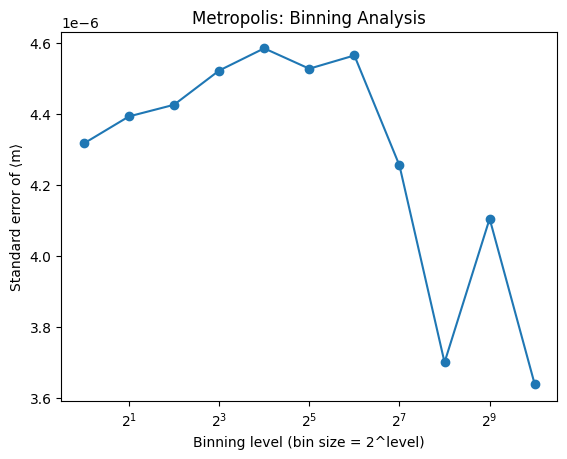

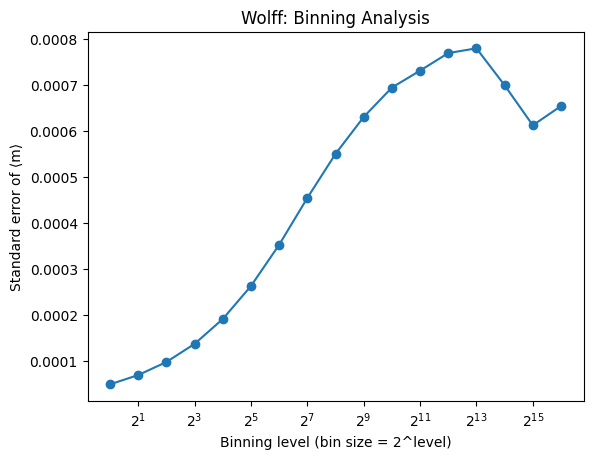

In [18]:
import matplotlib.pyplot as plt

levels, errors, binned = binning_analysis(M_vals_metropolis)

plt.plot(levels, errors, '-o')
plt.title("Metropolis: Binning Analysis")
plt.xlabel("Binning level (bin size = 2^level)")
plt.ylabel("Standard error of ⟨m⟩")
plt.xscale("log", base=2)
plt.show()

levels, errors, binned = binning_analysis(M_vals_wolff)

plt.plot(levels, errors, '-o')
plt.title("Wolff: Binning Analysis")
plt.xlabel("Binning level (bin size = 2^level)")
plt.ylabel("Standard error of ⟨m⟩")
plt.xscale("log", base=2)
plt.show()


## 5. Compare the two flipping algorithms

Plot the magnetisation (Sum over the spins, and divide by the size of the system) as a function of number of iterations. Do this for a low temperature. which method converges faster?

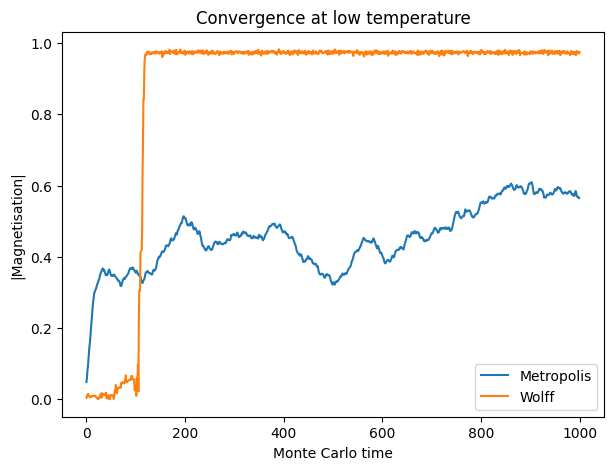

In [19]:
L = 100
beta = 0.6
n_steps = 1000

field = random_spin_field(L, L)
field_m = field.copy()
field_w = field.copy()

M_metropolis = []
M_wolff = []

for sweep in range(n_steps):
    cy_ising_step(field_m, beta)
    M_metropolis.append(abs(magnetisation(field_m)))

time = 0.0
while time < n_steps:
    cluster_size = wolff_step(field_w, beta)
    time += cluster_size / field_w.size
    M_wolff.append(abs(magnetisation(field_w)))

plt.figure(figsize=(7,5))
plt.plot(np.arange(0, n_steps, 1), M_metropolis, label="Metropolis")
plt.plot(np.linspace(0, n_steps, len(M_wolff)), M_wolff, label="Wolff")
plt.xlabel("Monte Carlo time")
plt.ylabel("|Magnetisation|")
plt.legend()
plt.title("Convergence at low temperature")
plt.show()

## 6. Magnetisation v/s temperature

Plot magnetisation as a function of temperature for three different lattice sizes, say 8,10 and 12.

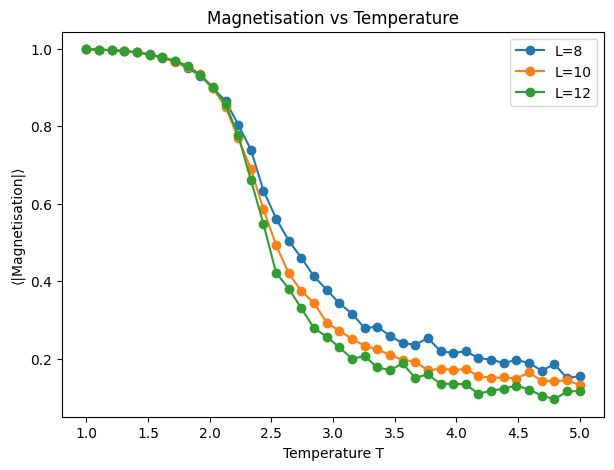

In [20]:
Ls = [8, 10, 12]
T_vals = np.linspace(1, 5, 40)
field = random_spin_field(L, L)

n_therm = 500
n_meas = 1000

plt.figure(figsize=(7,5))

for L in Ls:
    M_T = []

    for T in T_vals:
        beta = 1.0 / T
        field = random_spin_field(L, L)

        for _ in range(n_therm):
            wolff_step(field, beta)

        M_vals = []
        for _ in range(n_meas):
            wolff_step(field, beta)
            M_vals.append(abs(magnetisation(field)))

        M_T.append(np.mean(M_vals))

    plt.plot(T_vals, M_T, marker='o', label=f"L={L}")

plt.xlabel("Temperature T")
plt.ylabel("⟨|Magnetisation|⟩")
plt.title("Magnetisation vs Temperature")
plt.legend()
plt.show()


## 7. Autocorrelation time v/s temperature

Find the autocorrelation time as a function of temperature for both the cluster flipping algorithms (single spin and Swendsen-Wang/Wolff). Which algortihm has a longer autocorrelation time? Is the result expected? Based on magnetisation v/s temperature and autocorrelation time v/s temperature, can you identify the critical temperature (this is harder than percolation theory as your graphs will be noisier, it is fine if it is a bit off)

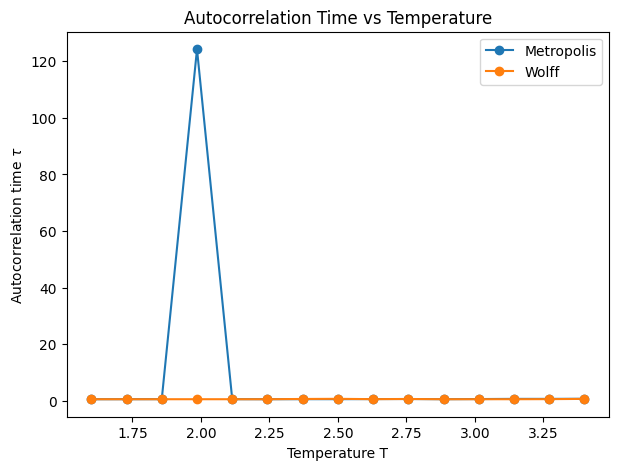

In [23]:
def autocorr_time(series, max_lag=None):
    x = np.array(series, dtype=float)
    x -= np.mean(x)
    N = len(x)

    if max_lag is None:
        max_lag = N // 10

    c0 = np.dot(x, x) / N
    tau = 0.5  # lag 0 contribution

    for t in range(1, max_lag):
        ct = np.dot(x[:-t], x[t:]) / (N - t)
        rho = ct / c0
        if rho <= 0:
            break
        tau += rho

    return tau


L = 30
T_vals = np.linspace(1.6, 3.4, 15)

n_therm = 500      # thermalisation time (MC units)
n_meas = 3000      # number of measurements


tau_metropolis = []

for T in T_vals:
    beta = 1.0 / T
    field = random_spin_field(L, L)

    # thermalisation
    for _ in range(n_therm):
        cy_ising_step(field, beta)

    # measurements (1 sweep = 1 MC time)
    M_series = []
    for _ in range(n_meas):
        cy_ising_step(field, beta)
        M_series.append(magnetisation(field))

    tau_metropolis.append(autocorr_time(M_series))


tau_wolff = []

for T in T_vals:
    beta = 1.0 / T
    field = random_spin_field(L, L)

    # thermalisation
    time = 0.0
    while time < n_therm:
        cluster_size = wolff_step(field, beta)
        time += cluster_size / field.size

    # measurements at fixed MC time intervals
    M_series = []
    time = 0.0
    next_sample_time = 1.0

    while len(M_series) < n_meas:
        cluster_size = wolff_step(field, beta)
        time += cluster_size / field.size

        if time >= next_sample_time:
            M_series.append(magnetisation(field))
            next_sample_time += 1.0

    tau_wolff.append(autocorr_time(M_series))


plt.figure(figsize=(7,5))
plt.plot(T_vals, tau_metropolis, '-o', label="Metropolis")
plt.plot(T_vals, tau_wolff, '-o', label="Wolff")
plt.xlabel("Temperature T")
plt.ylabel("Autocorrelation time $\\tau$")
plt.title("Autocorrelation Time vs Temperature")
plt.legend()
plt.show()


## 8. Specific heat

Find the specific heat as a function of temperature for different lattice sizes, say 8,12 and 16. Use the following formula for specific heat

$$C_V = \frac{\langle E^2 \rangle - \langle E \rangle^2}{NT^2}  $$

Do you see the phase transition?

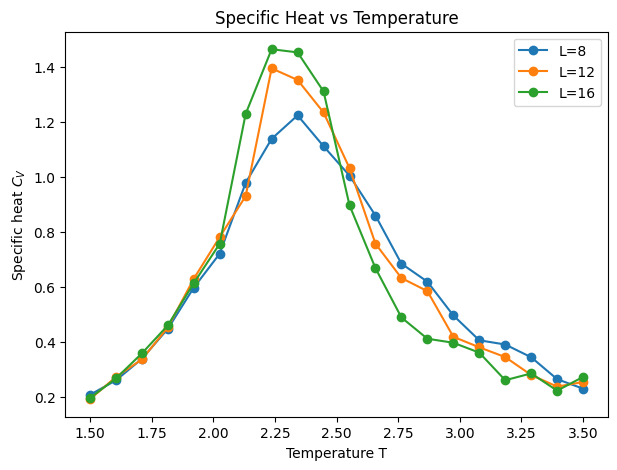

In [23]:
def energy(field):
    N, M = field.shape
    E = 0
    for i in range(N):
        for j in range(M):
            E -= field[i, j] * (
                field[(i+1)%N, j] + field[i, (j+1)%M]
            )
    return E


Ls = [8, 12, 16]
T_vals = np.linspace(1.5, 3.5, 20)

n_therm = 500
n_meas = 2000

plt.figure(figsize=(7,5))

for L in Ls:
    Cv_T = []

    for T in T_vals:
        beta = 1.0 / T
        field = random_spin_field(L, L)

        # thermalisation
        for _ in range(n_therm):
            wolff_step(field, beta)

        E_vals = []
        for _ in range(n_meas):
            wolff_step(field, beta)
            E_vals.append(energy(field))

        E_vals = np.array(E_vals)
        Cv = (np.mean(E_vals**2) - np.mean(E_vals)**2) / (L*L*T*T)
        Cv_T.append(Cv)

    plt.plot(T_vals, Cv_T, '-o', label=f"L={L}")

plt.xlabel("Temperature T")
plt.ylabel("Specific heat $C_V$")
plt.title("Specific Heat vs Temperature")
plt.legend()
plt.show()

## 8. Bonus 1: The XY model

In XY model, the spins are a 2D unit vector. Perform the same procedure as above, for only Swendsen-Wang/Wolff algorithm. Is the phase transition looking weird?

Hint: Evaluate the specific heat v/s temperature plot

In [ ]:
0

## 9 Bonus 2: Unsupervised Learning

Here we are going to use a method called Principal Component Analysis (PCA). We will use the function sklearn.decomposition.PCA

Find out what PCA does by looking up this function's documentation. Take a random value of temperature from 1.6 to 3, and initialise a system. Let it reach the equilibrium, by letting it evolve by doing 500 Swendsen-Wang/Wolff cluster flips. Flatten each of these 500 equilibriated systems into 1D arrays, and append these arrays together, creating an array which consists of 500 arrays. Keep track of what is the temperature these systems were equilibriated at in a separate 1D array.

Perform PCA of this data. Plot the first and the second component of PCA against each other, and label the scatter plots with temperature. What do you see? Can you differentiate between the magnetised and non-magnetised state? Why is this happening, what do these principal components represent?